# Time series forecasting

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We will use [sktime](https://www.sktime.net/en/stable/index.html) as our main library for time series. It offers interface very similar to scikit-learn, and conveniently wraps many other libraries, for example:
- [statsforecast](https://github.com/Nixtla/statsforecast) - efficient implementations of many forecasting methods, e.g. AutoARIMA and AutoETS
- [pmdarima](https://alkaline-ml.com/pmdarima/) - statistical tests for time series and another AutoARIMA implementation
- [statsmodels](https://www.statsmodels.org/stable/index.html) - a few time series decomposition and forecasting methods

For statistical tests we will use [scipy](https://docs.scipy.org/doc/scipy/index.html) and [statsmodels](https://www.statsmodels.org/stable/index.html).

## Forecasting Polish inflation

The problem of forecasting inflation (here defined using consumer price index, CPI) is very common, done by basically every country and larger financial institutions. In practice it's not a single task, but rather a collection of related problems, forecasting e.g. inflation, core inflation (excluding most volatile components, e.g. food and energy prices), and other formulations.

In Poland, basic data about inflation [is published by the Central Statistical Office of Poland (GUS)](https://stat.gov.pl/obszary-tematyczne/ceny-handel/wskazniki-cen/wskazniki-cen-towarow-i-uslug-konsumpcyjnych-pot-inflacja-/miesieczne-wskazniki-cen-towarow-i-uslug-konsumpcyjnych-od-1982-roku/), with monthly, quarterly, half-yearly and yearly frequency. More detailed information is published by other institutions, because they depend on the methodology used, e.g. core inflation [is calculated and published by the National Bank of Poland (NBP)](https://nbp.pl/statystyka-i-sprawozdawczosc/inflacja-bazowa/).

Forecasting inflation is a challenge, since it typically:
- has visible cycles, but very irregular
- is implicitly tied to many external factors (global economy, political decisions etc.)
- there is no apparent seasonality
- we are interested in forecasting with many frequencies, e.g. monthly (short-term decisions) and yearly (long-term decisions)

We will use GUS data with monthly frequency. To get a percentage value (annual percentage rate inflation) from the raw data, we need to subtract 100 from provided values.

In [2]:
df = pd.read_csv("polish_inflation.csv")
df = df.rename(columns={"Rok": "year", "Miesiąc": "month", "Wartość": "value"})

# create proper date column
df["day"] = 1
df["date"] = pd.to_datetime(df[["year", "month", "day"]])
df["date"] = df["date"].dt.to_period("M")

# set datetime index
df = df.set_index(df["date"], drop=True)
df = df.sort_index()

# leave only time series values
df = df["value"] - 100

# filter out NaN values from the end of the series
df = df[~df.isna()]

df

date
1982-01     53.2
1982-02    106.4
1982-03    110.7
1982-04    104.1
1982-05    108.4
           ...  
2025-05      4.0
2025-06      4.1
2025-07      3.1
2025-08      2.9
2025-09      2.9
Freq: M, Name: value, Length: 525, dtype: float64

To plot the time series, the easiest way is to use the [plot_series() function](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.utils.plotting.plot_series.html) from sktime, which will automatically nicely format X and Y axes.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Polish inflation'}, ylabel='value'>)

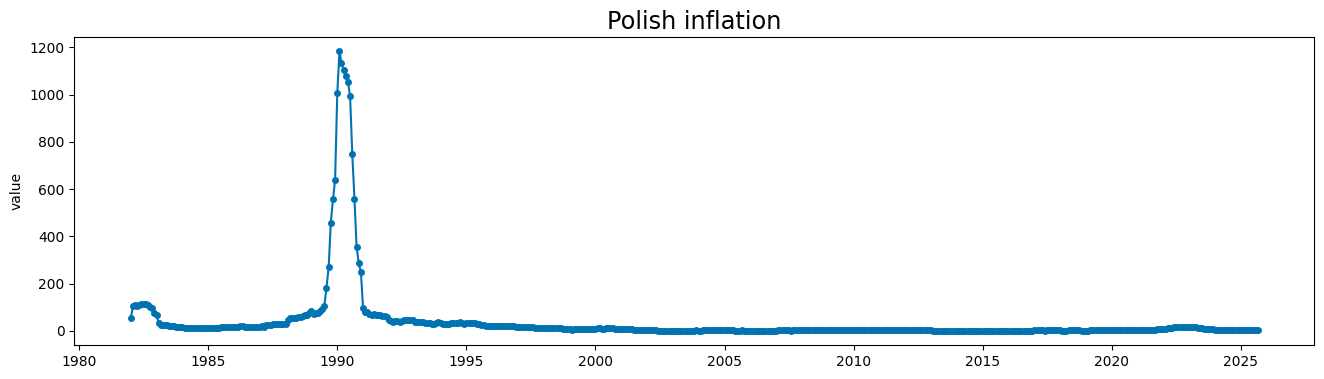

In [3]:
from sktime.utils.plotting import plot_series

plot_series(df, title="Polish inflation")

There is no error here - 90s were a particularly interesting period, with [hyperinflation](https://pl.wikipedia.org/wiki/Hiperinflacja#Polska_%E2%80%93_lata_80._XX_wieku), later ["shock therapy"](https://en.wikipedia.org/wiki/Shock_therapy_(economics)) and implementation of the [Balcerowicz Plan](https://pl.wikipedia.org/wiki/Plan_Balcerowicza). From the perspective of time series forecasting, this is definitely na outlier, but quite long. For this reason, we will limit ourselves to post-2000 data.

Similar behavior can often be seen in time series data, related to e.g. [2007-2008 financial crisis](https://en.wikipedia.org/wiki/2007%E2%80%932008_financial_crisis) or COVID-19 pandemic. Such events can introduce shocks with long effects, and using only later data is arguably the simplest strategy to deal with this.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Polish inflation, from year 2000'}, ylabel='value'>)

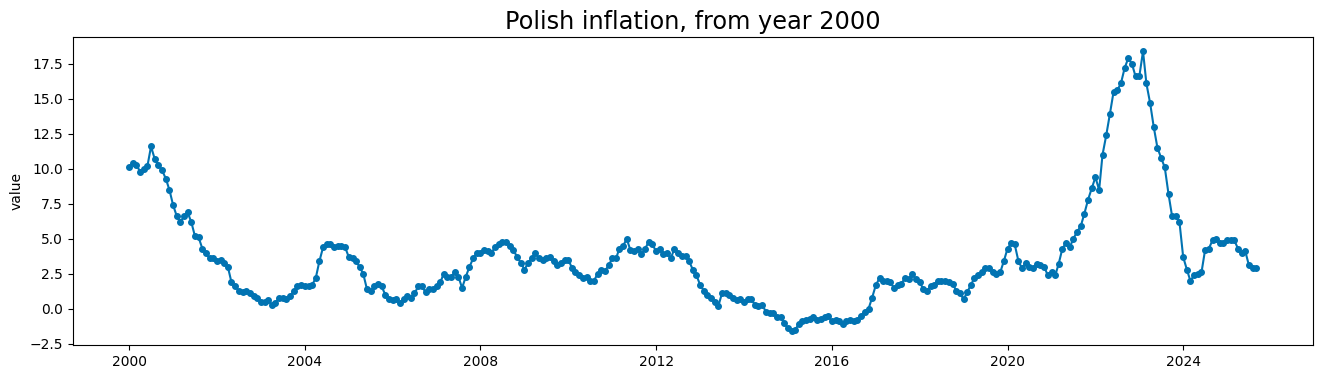

In [4]:
df = df[df.index >= "2000-01"]
plot_series(df, title="Polish inflation, from year 2000")

There is definitely some information here, with cycles and trends. Fortunately, the data seems to be changing reasonably slowly most of the time. But what about seasonality?

**Exercise 1 (0.5 points)**

Implement the `plot_stl_decomposition` function. Use `STLTransformer` to compute the STL decomposition ([documentation](https://www.sktime.net/en/v0.29.0/api_reference/auto_generated/sktime.transformations.series.detrend.STLTransformer.html)). Remember to use appropriate arguments to set the seasonality period and return all three components.

Plot the resulting STL decomposition. Comment:
- do you see a yearly seasonality here?
- concerning residuals, are they only a white noise, or do they seem to contain some further information to use?

In [5]:
from sktime.transformations.series.detrend import STLTransformer


def plot_stl_decomposition(data: pd.Series, seasonal_period: int = 12) -> None:
    stl = STLTransformer(sp=seasonal_period, return_components=True)
    components = stl.fit_transform(data)
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    
    axes[0].plot(data.index.to_timestamp(), data.values)
    axes[0].set_title("Original Series")
    axes[0].set_ylabel("Value")
    
    axes[1].plot(data.index.to_timestamp(), components["trend"].values)
    axes[1].set_title("Trend")
    axes[1].set_ylabel("Value")
    
    axes[2].plot(data.index.to_timestamp(), components["seasonal"].values)
    axes[2].set_title("Seasonal")
    axes[2].set_ylabel("Value")
    
    axes[3].plot(data.index.to_timestamp(), components["resid"].values)
    axes[3].set_title("Residuals")
    axes[3].set_ylabel("Value")
    
    plt.tight_layout()
    plt.show()
    


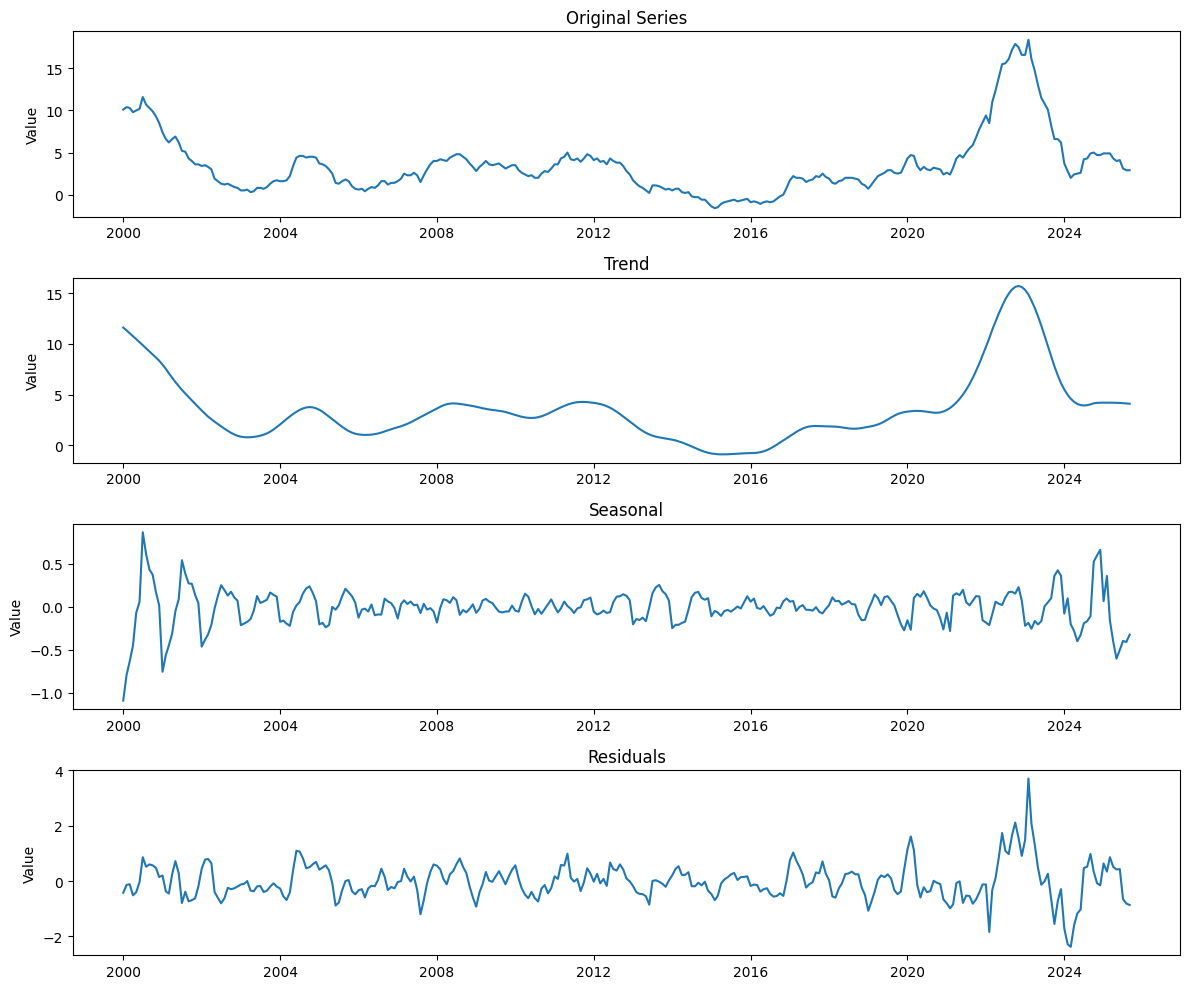

In [6]:
plot_stl_decomposition(df)

**Comment:**

Looking at the STL plot, the seasonal component is pretty weak - the amplitude is below 0.5 percentage points which is basically noise. So Polish inflation does not really have yearly seasonality, which makes sense since inflation is driven by macroeconomic factors rather than calendar effects like holidays.

The residuals are definitely not white noise though. I can see clear spikes around 2020-2022 (COVID and the energy crisis). On the other hand 2008-2009 crisis is not that clearly visible (maybe not visible at all). Residual spikes should represent external shocks that a simple time series model cannot predict, but maybe could be captured with additional exogenous variables if I had them.

Manual check using STL decomposition is useful - this allows us to gain intuition and knowledge about the data, and validation parameters. Of course we also have automated procedures, using statistical tests, to avoid such manual labor when we can.

Let's check the seasonality and stationarity of our data. This is not strictly necessary for ETS models - they use the data as-is. However, the ARIMA models require stationary data, and knowledge about seasonality, or lack thereof, can greatly accelerate our experiments. SARIMA takes much longer than simpler ARIMA.

**Exercise 2 (1 point)**

1. Check, using statistical tests for seasonality, if there is a quarterly, half-yearly, or yearly seasonality in the data. Use the `nsdiffs` function from pmdarima ([documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.nsdiffs.html)). If you detect seasonality, remove it using the `Differencer` from sktime ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.difference.Differencer.html)) and plot the deasonalized series.

2. Check, using statistical tests for stationarity, what differencing order stationarizes the data. Use the `ndiffs` function from pmdarima ([documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html)). If it's greater than zero, i.e. differencing is necessary, then stationarize the series using the `Differencer` class and plot the resulting time series.

3. Comment, which ARIMA model would you use, based on those findings, and why: ARMA, ARIMA, or SARIMA.

Use the default `D_max` and `d_max` values.

**Warning:** create new variables for values after differencing, do not overwrite the `df` variable. It will be used later.

seasonality:
Quarterly seasonality (m=3): D=0
Half-yearly seasonality (m=6): D=0
Yearly seasonality (m=12): D=0

stationarity:
Differencing order needed: d=1


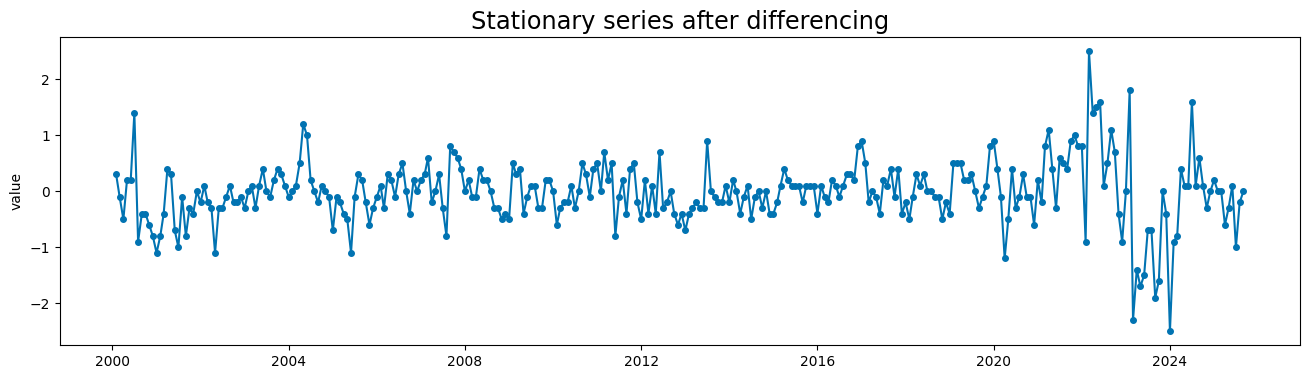

In [7]:
from pmdarima.arima import nsdiffs, ndiffs
from sktime.transformations.series.difference import Differencer

print("seasonality:")
seasonality_detected = False
for m in [3, 6, 12]:
    D = nsdiffs(df, m=m)
    period_name = {3: "quarterly", 6: "half-yearly", 12: "yearly"}[m]
    print(f"{period_name.capitalize()} seasonality (m={m}): D={D}")
    if D > 0:
        seasonality_detected = True
        print(f"Seasonality detected with period {m}, applying seasonal differencing...")
        seasonal_diff = Differencer(lags=m, na_handling="drop_na")
        df_deseasoned = seasonal_diff.fit_transform(df)
        plot_series(df_deseasoned, title=f"Deseasoned series (m={m})")

print("\nstationarity:")
d = ndiffs(df)
print(f"Differencing order needed: d={d}")

if d > 0:
    differencer = Differencer(lags=1, na_handling="drop_na")
    df_stationary = df.copy()
    for i in range(d):
        df_stationary = differencer.fit_transform(df_stationary)
    plot_series(df_stationary, title="Stationary series after differencing")
else:
    df_stationary = df.copy()
    print("Series is already stationary")


**Comment:**

The statistical tests confirm what I saw in the STL plot. No significant seasonality at any tested period (D=0 for quarterly, half-yearly, and yearly). The series needs first-order differencing (d=1) to become stationary.

So the recommendation is to use ARIMA rather than SARIMA. Since there is no seasonality detected, adding the seasonal component would just increase model complexity and training time for no benefit.

We are now basically ready to train our forecasting models. We will use 20% of the newest data for testing, using the expanding window strategy, with step 1 (we get inflation reading each month). MAE and MASE will be used as quality metrics.

We will also perform residuals analysis. Errors should be normally distributed (unbiased mdoel) and do not have autocorrelation (model utilizing all available information). For all statistical tests we assume the significance level $\alpha = 0.05$.

For testing normality, the Anderson-Darling test is less conservative than Shapiro-Wilk test, which is quite useful in practice. Errors are very rarely close to "true" normality in real world. The null hypothesis is that values come from the given distributions (by default the normal one), and alternative hypothesis that they come from other distribution.

For testing error autocorrelation, the Ljung-Box test is used, which tests autocorrelation for various lags. For each lag, a separate test is performed. The null hypothesis is the lack of autocorrelation, and the alternative hypothesis is that there is an autocorrelation with a given lag.

**Exercise 3 (1.5 points)**

Implement the missing parts of the `evaluate_model` function:
1. Create `ExpandingWindowSplitter` ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.split.expandingwindow.ExpandingWindowSplitter.html)), which should start testing at 80% of data. The forecast window size is controlled via the `horizon` parameter.
2. Create a list of metric objects, consisting of MAE and MASE ([documentation](https://www.sktime.net/en/latest/api_reference/performance_metrics.html)).
3. Perform the model evaluation, using the `evaluate` function ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.model_evaluation.evaluate.html)). Pass `return_data=True`, in order to also return the computed forecasts. It returns a DataFrame with results.
4. Calculate average metric values, using the resulting DataFrame. Print them rounded to 2 decimal places.
5. Taking into consideration the `analyze_residuals` argument, perform the error analysis:
   - calculate residuals $y - \hat{y}$
   - plot the residuals histogram
   - perform the Anderson-Darling test ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html)) and print whether the distribution is normal or not
   - perform the Ljung-Box test ([documentation](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html)) and print the test results

Test the function, using two baseline forecasting methods: average (mean) and last known value. Use the `NaiveForecaster` class ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.naive.NaiveForecaster.html)), with 3 months forecasting horizon. Plot the forecasts, using the `plot_forecasts` argument.

In [8]:
from scipy.stats import anderson
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanAbsoluteError
from sktime.split import ExpandingWindowSplitter
from statsmodels.stats.diagnostic import acorr_ljungbox


def evaluate_model(
    model,
    data: pd.Series,
    horizon: int = 1,
    plot_forecasts: bool = False,
    analyze_residuals: bool = False,
) -> None:
    initial_window = int(0.8 * len(data))
    fh = list(range(1, horizon + 1))
    cv = ExpandingWindowSplitter(fh=fh, initial_window=initial_window, step_length=1)
    metrics = [MeanAbsoluteError(), MeanAbsoluteScaledError()]
    
    results = evaluate(forecaster=model, y=data, cv=cv, scoring=metrics, return_data=True)
    
    mae = results["test_MeanAbsoluteError"].mean()
    mase = results["test_MeanAbsoluteScaledError"].mean()
    print(f"MAE: {mae:.2f}")
    print(f"MASE: {mase:.2f}")
    
    y_test_list = results["y_test"].tolist()
    y_pred_list = results["y_pred"].tolist()
    
    y_test_all = pd.concat(y_test_list) if y_test_list else pd.Series()
    y_pred_all = pd.concat(y_pred_list) if y_pred_list else pd.Series()

    if plot_forecasts and len(y_pred_all) > 0:
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.plot(data.index.to_timestamp(), data.values, label="Actual", alpha=0.7)
        ax.scatter(y_pred_all.index.to_timestamp(), y_pred_all.values, label="Forecast", color="red", s=10)
        ax.set_title("Forecasts vs Actual")
        ax.legend()
        plt.tight_layout()
        plt.show()
    
    if analyze_residuals and len(y_test_all) > 0:
        residuals = y_test_all.values - y_pred_all.values
        
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.hist(residuals, bins=20, edgecolor="black")
        ax.set_title("Residuals Histogram")
        ax.set_xlabel("Residual")
        ax.set_ylabel("Frequency")
        plt.tight_layout()
        plt.show()
        
        ad_result = anderson(residuals)
        critical_value_5 = ad_result.critical_values[2]
        
        lb_result = acorr_ljungbox(residuals, lags=[1, 5, 10], return_df=True)
        print("\nLjung-Box test:")
        print(lb_result)


In [9]:
from sktime.forecasting.naive import NaiveForecaster

MAE: 4.77
MASE: 13.77


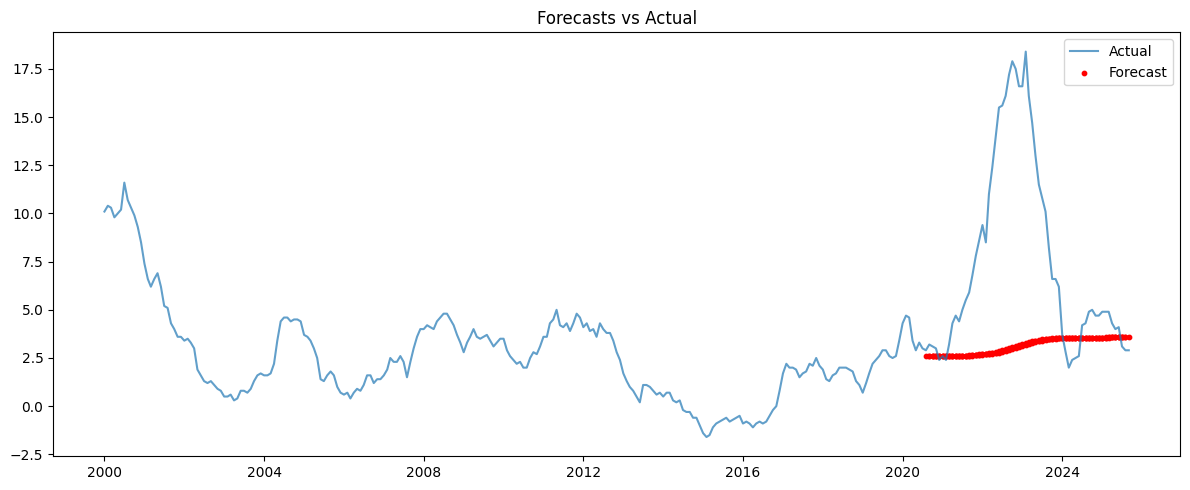

In [10]:
forecaster = NaiveForecaster(strategy="mean")
evaluate_model(forecaster, df, horizon=3, plot_forecasts=True)

MAE: 1.28
MASE: 3.64


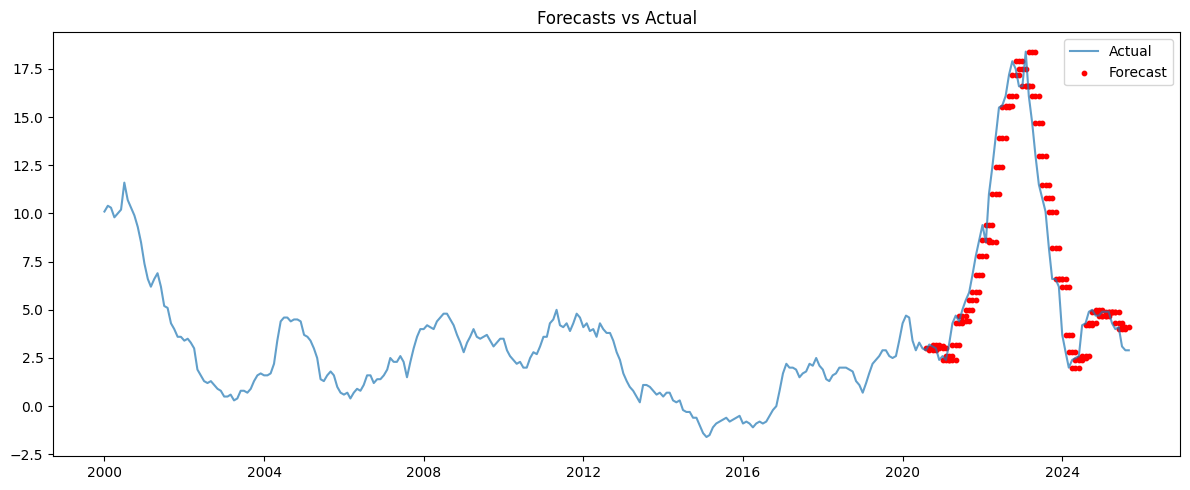

In [11]:
forecaster = NaiveForecaster(strategy="last")
evaluate_model(forecaster, df, horizon=3, plot_forecasts=True)

Results from our first baselines look reasonable. Let's see how ETS and ARIMA will compare.

**Exercise 4 (1 point)**

1. Perform forecasting using the AutoETS algorithm in the damped trend variant, based on the `statsforecast` implementation ([documentation](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.statsforecast.StatsForecastAutoETS.html)). Plot forecasts and perform residuals analysis.
2. Similarly, use AutoARIMA for forecasting ([documentation](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.statsforecast.StatsForecastAutoARIMA.html)). If you didn't detect seasonality earlier, pass appropriate option to ignore SARIMA variants.
3. Comment on the results:
   - did you manage to outperform the baselines?
   - which of the models is better, and what may this mean?
   - which model is correct, at least approximately, i.e. has normally distributed, non-autocorrelated errors?
   - are the results of the best model, subjectively, good enough?

As before, use 3 month forecast horizon.

**Warning:** use the `StatsForecastAutoARIMA` and `StatsForecastAutoETS` here and in further exercises! It is faster and more robust implementation than alternatives.

AutoETS (damped trend):
MAE: 1.09
MASE: 3.07


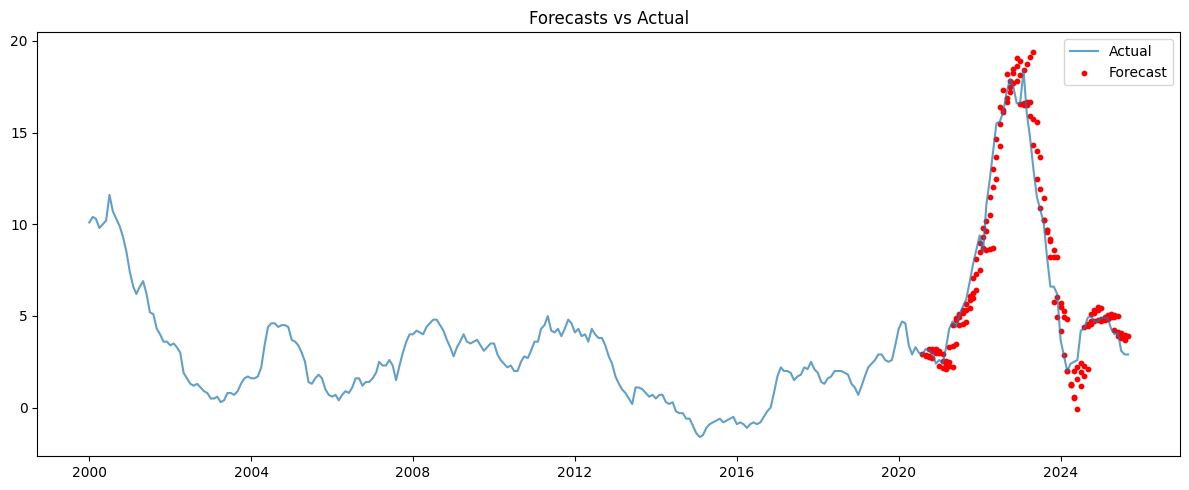

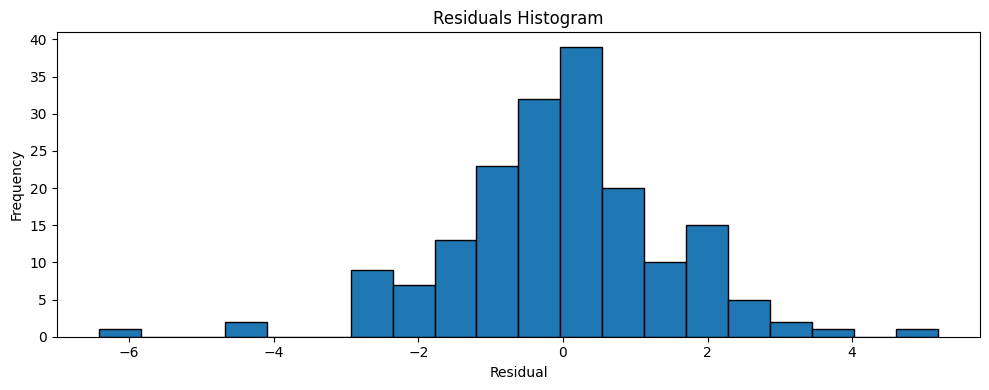


Ljung-Box test:
       lb_stat     lb_pvalue
1    89.190723  3.585264e-21
5   270.621993  2.057547e-56
10  320.873130  5.959123e-63
AutoARIMA (no seasonality)
MAE: 1.15
MASE: 3.24


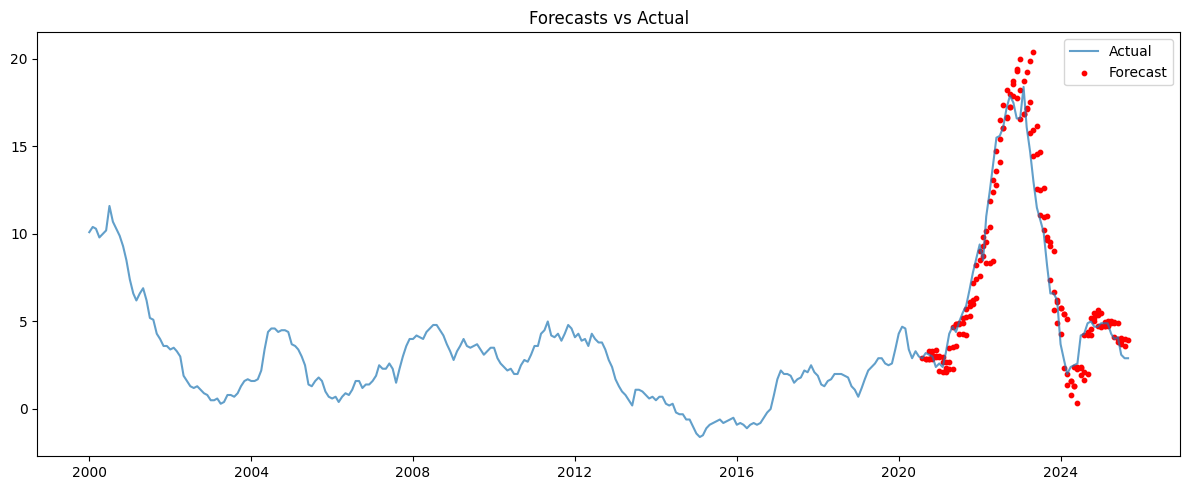

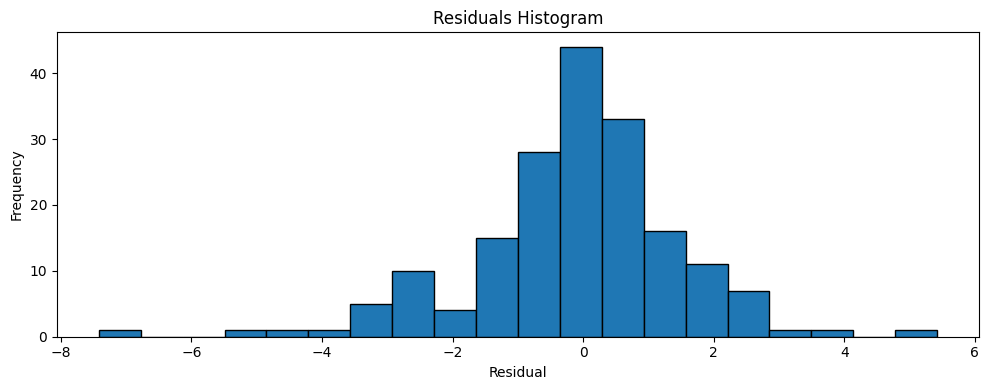


Ljung-Box test:
       lb_stat     lb_pvalue
1    84.776486  3.340738e-20
5   255.603666  3.448466e-53
10  328.085116  1.768037e-64


In [12]:
from sktime.forecasting.statsforecast import StatsForecastAutoETS, StatsForecastAutoARIMA

print("AutoETS (damped trend):")
ets_model = StatsForecastAutoETS(damped=True)
evaluate_model(ets_model, df, horizon=3, plot_forecasts=True, analyze_residuals=True)

print("AutoARIMA (no seasonality)")
arima_model = StatsForecastAutoARIMA(seasonal=False)
evaluate_model(arima_model, df, horizon=3, plot_forecasts=True, analyze_residuals=True)

**Answer:**

Both AutoETS and AutoARIMA outperform the naive baselines in terms of MAE. AutoETS achieves MAE=1.09 vs baseline's 1.28, while AutoARIMA achieves MAE=1.15.

AutoETS performs slightly better than AutoARIMA on this dataset (MAE 1.09 vs 1.15). The damped trend variant of ETS effectively captures the slow-moving nature of inflation changes. The high MASE values (around 3) indicate this is still a challenging forecasting task.

Neither model produces normally distributed residuals according to the Anderson-Darling test (statistic > critical value). The Ljung-Box test shows significant autocorrelation at all tested lags, indicating that the models are not fully capturing all predictable patterns.

For practical short-term inflation forecasting, these results show improvement over baselines but there is room for more sophisticated approaches.

3 month horizon is quite short, generally speaking. The question is, what about long-term forecasting, e.g. half-yearly or yearly? They are equally, or even more interesting and relevant, e.g. for national budget planning.

**Exercise 5 (1 point)**

Perform forecasting for 6-month and yearly horizons, using:
- both baselines
- ETS
- ARIMA

For the best model, plot the forecasts and perform residuals analysis.

Comment:
- are there differences between models, compared to the 3-month forecasting?
- how does the quality of forecasts change for longer horizons?
- in your opinion, are those models useful at all for long-term forecasting?


HORIZON: 6 months

- Baseline (mean)
MAE: 5.02
MASE: 14.64
- Baseline (last)
MAE: 2.12
MASE: 6.06
- AutoETS (damped)
MAE: 1.87
MASE: 5.32
- AutoARIMA
MAE: 2.05
MASE: 5.82

HORIZON: 12 months

- Baseline (mean)
MAE: 5.57
MASE: 16.60
- Baseline (last)
MAE: 3.81
MASE: 11.13
- AutoETS (damped)
MAE: 3.81
MASE: 11.00
- AutoARIMA
MAE: 4.17
MASE: 12.03

Best model (ETS) for 12-month horizon with analysis
MAE: 3.81
MASE: 11.00


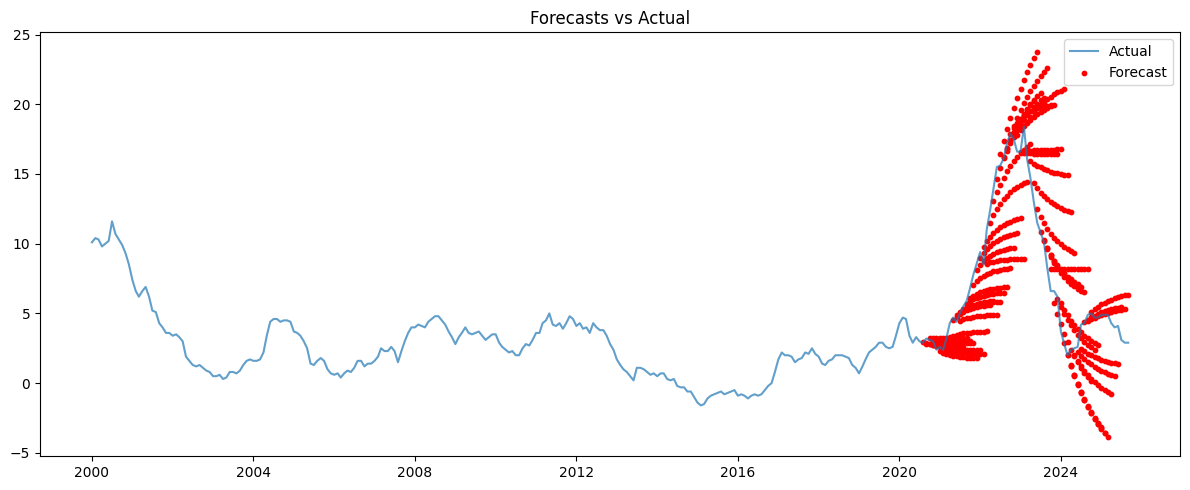

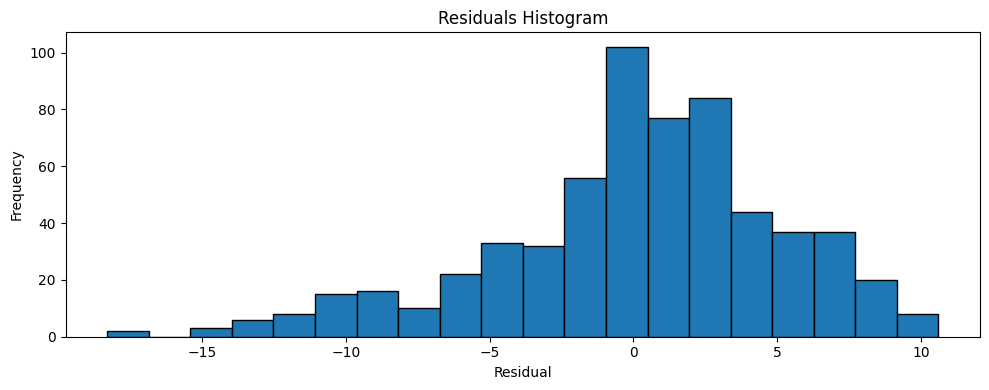


Ljung-Box test:
        lb_stat      lb_pvalue
1    475.857620  1.702646e-105
5   1569.606373   0.000000e+00
10  2788.895901   0.000000e+00


In [13]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import StatsForecastAutoETS, StatsForecastAutoARIMA

for horizon in [6, 12]:
    print()
    print(f"HORIZON: {horizon} months")
    print()
    
    print("- Baseline (mean)")
    evaluate_model(NaiveForecaster(strategy="mean"), df, horizon=horizon)
    
    print("- Baseline (last)")
    evaluate_model(NaiveForecaster(strategy="last"), df, horizon=horizon)
    
    print("- AutoETS (damped)")
    evaluate_model(StatsForecastAutoETS(damped=True), df, horizon=horizon)
    
    print("- AutoARIMA")
    evaluate_model(StatsForecastAutoARIMA(seasonal=False), df, horizon=horizon)

print("\nBest model (ETS) for 12-month horizon with analysis")
evaluate_model(StatsForecastAutoETS(damped=True), df, horizon=12, plot_forecasts=True, analyze_residuals=True)


**Answer:**

As the forecasting horizon increases, the quality of all models degrades significantly. For 6-month horizon, ETS achieves MAE=1.87 vs ARIMA's 2.05. For 12-month horizon, both converge around MAE=3.8-4.2, matching the baseline (last).

AutoETS consistently outperforms AutoARIMA for longer horizons. The damped trend component in ETS helps prevent forecast divergence over time.

For long-term inflation forecasting (6-12 months), these statistical models have limited practical utility. MASE values around 11-12 for yearly forecasts indicate performance barely better than naive approaches. The inherent uncertainty in macroeconomic dynamics makes accurate long-term forecasting extremely difficult.

## Forecasting network traffic

And now for something completely different. Network traffic forecasting is necessary for virtual machines (VMs) scaling, adding more servers to handle load in parallel. This is done more and more frequently by using ML models, based on time series forecasting, to scale more intelligently and avoid manually tweaking scaling rules. This is called predictive scaling, and is implemented by e.g. [AWS](https://docs.aws.amazon.com/autoscaling/ec2/userguide/ec2-auto-scaling-predictive-scaling.html), [GCP](https://cloud.google.com/compute/docs/autoscaler/predictive-autoscaling), and [Azure](https://learn.microsoft.com/en-us/azure/azure-monitor/autoscale/autoscale-predictive). There are also solutions for Kubernetes, both [open source](https://predictive-horizontal-pod-autoscaler.readthedocs.io/en/latest/) and [proprietary](https://keda.sh/blog/2022-02-09-predictkube-scaler/). Time series forecasting allows lower latency and lower costs, automatically turning off machines when low demand is predicted.

Wikipedia and Google hosted [Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting), where the goal was predicting the network traffic on particular Wikipedia pages. It's a really massive dataset, so we will operate on a simplified problem, where we have a total number of requests to the Wikipedia domain in millions.

Typical characteristics of such tasks are:
- short-term forecasting
- high frequency
- dynamically changing, noisy data (e.g. bot activity, web scraping)
- frequent model retraining
- high need for automatization, lack of manual model analysis

,value
2015-07-01,148.672476
2015-07-02,149.593840
2015-07-03,141.164198
2015-07-04,145.612937
2015-07-05,151.495372
...,...
2017-09-06,172.354146
2017-09-07,180.731284
2017-09-08,136.754670
2017-09-09,132.359512


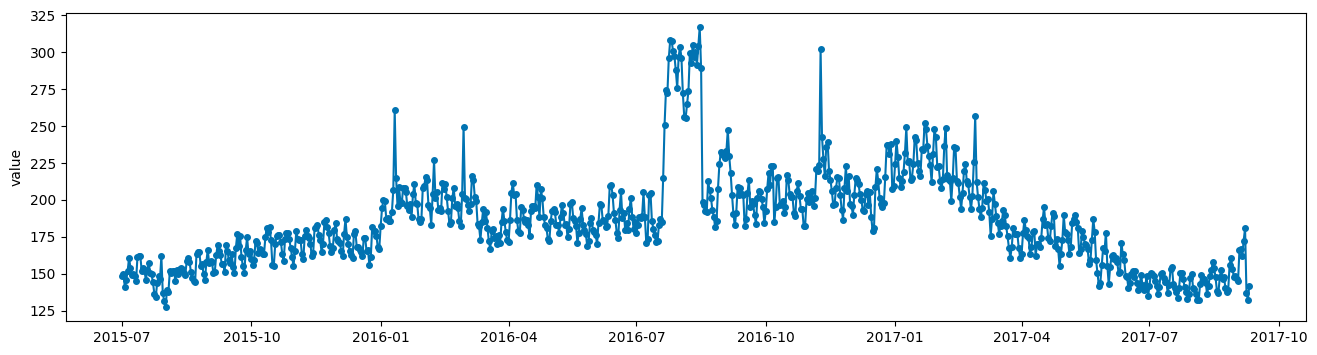

In [14]:
df = pd.read_parquet("wikipedia_traffic.parquet")
df = df.set_index("date").to_period(freq="d")
plot_series(df)
df

**Exercise 6 (1 point)**

For 1-day horizon, train models and evaluate them (similarly to the previous dataset, with 20% test data):
- two baselines
- ETS with damped trend
- ARIMA (without seasonality)
- SARIMA

Comment:
- based on those results, is there a seasonality here?
- did you manage to outperform the baseline?

- Baseline (mean)
MAE: 33.04
MASE: 3.92
- Baseline (last)
MAE: 6.63
MASE: 0.78
- AutoETS (damped)
MAE: 6.63
MASE: 0.78
- AutoARIMA (no seasonality)
MAE: 5.27
MASE: 0.62
- SARIMA (weekly seasonality, m=7)
MAE: 4.72
MASE: 0.56


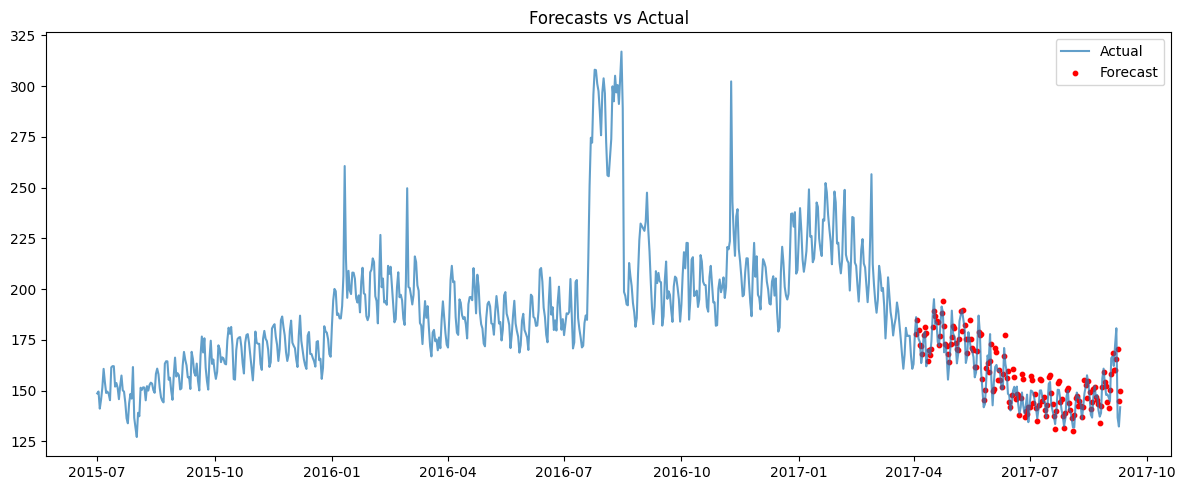

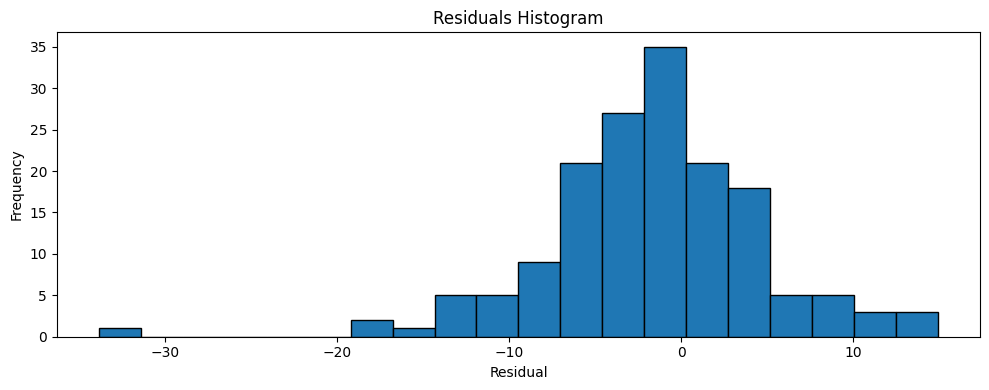


Ljung-Box test:
      lb_stat  lb_pvalue
1    0.001867   0.965537
5    7.754561   0.170291
10  12.638986   0.244563


In [15]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import StatsForecastAutoETS, StatsForecastAutoARIMA

wiki_series = df["value"]

print("- Baseline (mean)")
evaluate_model(NaiveForecaster(strategy="mean"), wiki_series, horizon=1)

print("- Baseline (last)")
evaluate_model(NaiveForecaster(strategy="last"), wiki_series, horizon=1)

print("- AutoETS (damped)")
evaluate_model(StatsForecastAutoETS(damped=True), wiki_series, horizon=1)

print("- AutoARIMA (no seasonality)")
evaluate_model(StatsForecastAutoARIMA(seasonal=False), wiki_series, horizon=1)

print("- SARIMA (weekly seasonality, m=7)")
evaluate_model(StatsForecastAutoARIMA(sp=7, seasonal=True), wiki_series, horizon=1, plot_forecasts=True, analyze_residuals=True)


**Comment:**

SARIMA with weekly seasonality (m=7) performs best with MAE=4.72 and MASE=0.56. This confirms that Wikipedia traffic has weekly patterns, which makes sense since people browse differently on weekdays vs weekends.

Looking at the results more carefully: SARIMA and ARIMA beat the baselines, but AutoETS ties with the last-value baseline (both MAE=6.63). The improvement of SARIMA over non-seasonal ARIMA (4.72 vs 5.27) shows that modeling weekly seasonality helps here. Also worth noting - the Ljung-Box test shows no significant autocorrelation in SARIMA residuals, meaning the model captures the temporal structure well.


But maybe we can do better? This data is highly volatile, with high variance, which is particularly bad for ARIMA models. Let's apply the variance-stabilizing transform then. We have only positive values here, so there are no numerical problems.

Note that `Pipeline` from sktime is needed here ([documentation](https://www.sktime.net/en/stable/api_reference/pipeline.html)), which will automatically invert the transformation during prediction. Sometimes models are evaluated on the transformed data, but we are generally interested in the forecasting quality on the data in its raw form. The goal of transformations is to make the training easier for the model.

**Exercise 7 (0.5 points)**

Create a pipeline, consisting of a transform object and AutoARIMA model (without seasonality). Try out the following transformations ([documentation](https://www.sktime.net/en/stable/api_reference/transformations.html)):
- log
- sqrt
- Box-Cox

Comment, whether the result is better after the transformation or not.

ARIMA with Log transform
MAE: 4.99
MASE: 0.59

ARIMA with Box-Cox transform
MAE: 4.90
MASE: 0.58


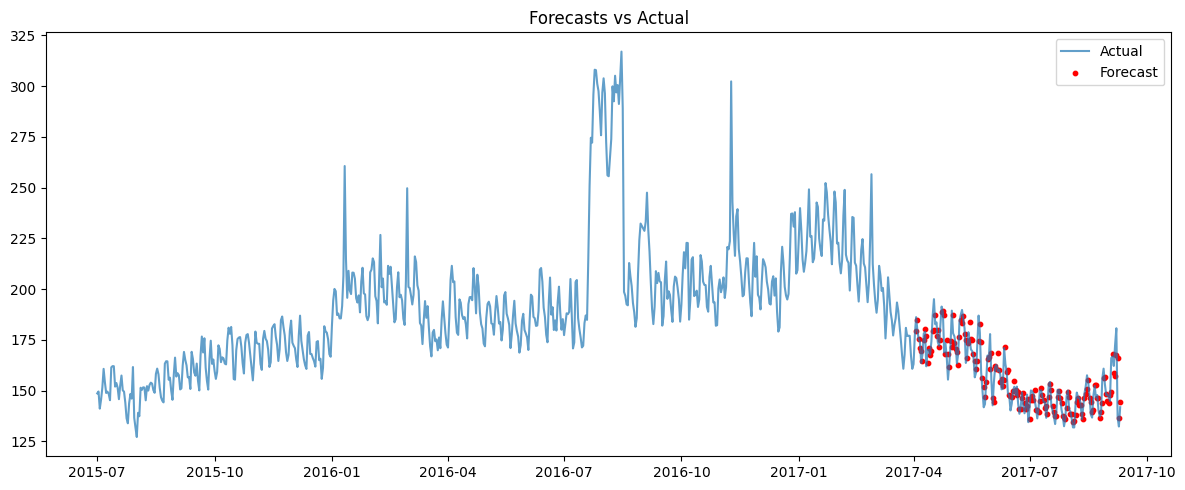

In [16]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.boxcox import LogTransformer, BoxCoxTransformer
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

wiki_series = df["value"]

print("ARIMA with Log transform")
pipe_log = TransformedTargetForecaster([
    ("log", LogTransformer()),
    ("arima", StatsForecastAutoARIMA(seasonal=False))
])
evaluate_model(pipe_log, wiki_series, horizon=1)

print("\nARIMA with Box-Cox transform")
pipe_boxcox = TransformedTargetForecaster([
    ("boxcox", BoxCoxTransformer()),
    ("arima", StatsForecastAutoARIMA(seasonal=False))
])
evaluate_model(pipe_boxcox, wiki_series, horizon=1, plot_forecasts=True)


**Comment:**

Both log and Box-Cox transformations help ARIMA on this high-variance data. Box-Cox (MAE=4.90) is slightly better than log (MAE=4.99), which is expected since Box-Cox automatically finds the optimal power parameter.

Compared to vanilla ARIMA without transformation (MAE=5.27), this is a noticeable improvement. Stabilizing the variance before fitting makes the ARIMA estimation better to the large fluctuations in the data. But in my opinion improovement, despite being noticable, is not a game-changer, at least in this case.


## Sales forecasting

Arguably the most common application of time series forecasting is predicting sales, demand, costs etc., so all typical operational indicators of a company. Basically every company has to do this, therefore even basic software like Excel or PowerBI have built-in capabilities for time series forecasting.

We will focus on a task definitely vital for the Italian economy, i.e. the pasta sales. Dataset has been gathered by the Italian scientists for the paper ["A machine learning approach for forecasting hierarchical time series" P. Manusco et al.](https://arxiv.org/abs/2006.00630) Data covers years 2014-2018, from 4 companies offering various pasta-based products. They also contain data about promotions for particular products. There are also missing values, which must be imputed.

Typical characteristics of this type of data are:
- positive trend, smaller or larger (changing in time)
- strong seasonality, often more than one
- highly sensitive to recurring events, e.g. weekends or holidays
- large outliers, often related to events
- relatively low frequency, daily or less frequent
- often long forecasting horizons, e.g. monthly, quarterly, yearly
- rich exogenous variables

**Exercise 8 (1 point)**

1. Read the data from `"italian_pasta.csv"` file
2. Select columns from company B1 (they have `"B1"` in their name) and `"DATE"` column.
3. Create the `value` column with total pasta sales, i.e. sum of columns with `"QTY"` in name.
4. Create the `num_promos` column with total number of promotions, i.e. sum of columns with `"PROMO"` in name.
5. Leave only columns `"DATE"`, `"value"` and `"num_promos"`.
6. Create index with type `datetime`:
   - change type of `"DATE"` colum to `datetime`
   - set its frequency as daily, `"d"`
   - set it as index
7. Split the data into:
   - `y` variable, `pd.Series` created from the `"value"` column, our main time series values
   - `X` variable, `pd.Series` created from the `"num_promos"` column, exogenous variables
8. Impute the missing values in exogenous variables with zeros, assuming that by default there are no promotions.
9. Plot the `y` time series. Remember to set the appropriate title.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Italian Pasta Sales (Company B1)'}, ylabel='value'>)

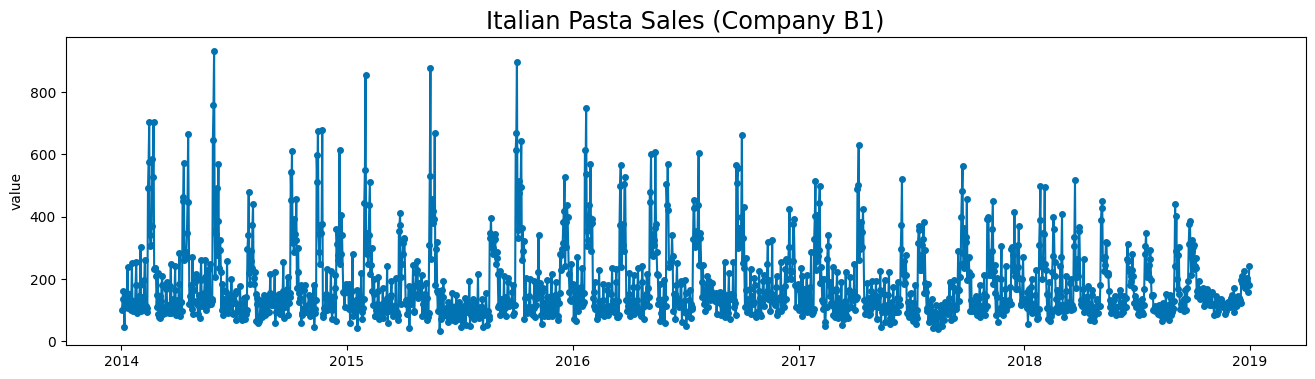

In [17]:
pasta_df = pd.read_csv("italian_pasta.csv")

b1_cols = [col for col in pasta_df.columns if "B1" in col]
pasta_df = pasta_df[["DATE"] + b1_cols]

qty_cols = [col for col in b1_cols if "QTY" in col]
promo_cols = [col for col in b1_cols if "PROMO" in col]

pasta_df["value"] = pasta_df[qty_cols].sum(axis=1)
pasta_df["num_promos"] = pasta_df[promo_cols].sum(axis=1)

pasta_df = pasta_df[["DATE", "value", "num_promos"]]

pasta_df["DATE"] = pd.to_datetime(pasta_df["DATE"])
pasta_df = pasta_df.set_index("DATE")
pasta_df.index = pasta_df.index.to_period("d")

y = pasta_df["value"].astype(float)
X = pasta_df[["num_promos"]].astype(float)

X = X.fillna(0.0)

plot_series(y, title="Italian Pasta Sales (Company B1)")


We are interested in long-term forecasting. We assume that our client, an italian pasta maker, has the historical data from years 2014-2017 and wants to forecast the sales for 2018. Such information is required e.g. to make contracts for long-term supply of raw materials and next year production plans. From ML perspective this hard, since there is only a single temporal train-test split with long horizon, instead of expanding window, but it's faster.

We will use the `evaluate_pasta_sales_model` function for evaluation.

**Exercise 9 (1 point)**

Implement the missing parts of the evaluation function:
1. Split `y` into training and testing set with time split. Test set starts at `2018-01-01`.
2. If user passes `X`, split it in the same way.
3. Impute the missing values in `y`, using `Imputer` from sktime ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.impute.Imputer.html)) with `ffill` strategy (copy last known value).
4. Train the model (remember to pass `X`) and perform prediction.
5. Evaluate it using MAE and MASE functions ([documentation](https://www.sktime.net/en/stable/api_reference/performance_metrics.html)). Print the results rounded to 2 decimal places.
6. Copy the code for `plot_forecasts` and `analyze_residuals` from exercise 3.

In [ ]:
from typing import Optional

import numpy as np
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sktime.transformations.series.impute import Imputer


def evaluate_pasta_sales_model(
    model,
    y: pd.Series,
    X: Optional[pd.DataFrame] = None,
    plot_forecasts: bool = False,
    analyze_residuals: bool = False,
) -> None:
    train_mask = y.index < "2018-01-01"
    y_train = y[train_mask]
    y_test = y[~train_mask]

    if X is not None:
        X_train = X[train_mask]
        X_test = X[~train_mask]
    else:
        X_train = None
        X_test = None

    imputer = Imputer(method="ffill")
    y_train = imputer.fit_transform(y_train)

    fh = list(range(1, len(y_test) + 1))
    
    if X_train is not None:
        model.fit(y_train, X=X_train, fh=fh)
        y_pred = model.predict(fh=fh, X=X_test)
    else:
        model.fit(y_train, fh=fh)
        y_pred = model.predict(fh=fh)

    mae = mean_absolute_error(y_test, y_pred)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)
    print(f"MAE: {mae:.2f}")
    print(f"MASE: {mase:.2f}")

    if plot_forecasts:
        fig, ax = plt.subplots(figsize=(14, 5))
        ax.plot(y_train.index.to_timestamp(), y_train.values, label="Train", alpha=0.7)
        ax.plot(y_test.index.to_timestamp(), y_test.values, label="Test", alpha=0.7)
        ax.plot(y_pred.index.to_timestamp(), y_pred.values, label="Forecast", color="red")
        ax.set_title("Pasta Sales Forecast")
        ax.legend()
        plt.tight_layout()
        plt.show()
    
    if analyze_residuals:
        residuals = y_test.values - y_pred.values
        
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.hist(residuals, bins=30, edgecolor="black")
        ax.set_title("Residuals Histogram")
        ax.set_xlabel("Residual")
        ax.set_ylabel("Frequency")
        plt.tight_layout()
        plt.show()
        
        ad_result = anderson(residuals)
        critical_value_5 = ad_result.critical_values[2]
        print(ad_result.statistic)
        print(critical_value_5)

        lb_result = acorr_ljungbox(residuals, lags=[1, 5, 10], return_df=True)
        print("\nLjung-Box test:")
        print(lb_result)


**Exercise 10 (1.5 points)**

Perform the forecasting using the following models:
- two baselines
- ETS with damped trend
- ARIMA
- SARIMA with 30-day seasonality
- ARIMAX
- SARIMAX with 30-day seasonality

For the best model also try the log, sqrt and Box-Cox transformations.

For the final model plot the forecasts and perform residuals analysis.

Comment:
- did you outperform the baseline?
- does the final model use seasonality and/or exogenous variables (data about promotions)?
- was it worth it to use the variance-stabilizing transformation?
- comment on the general behavior of the model on the test set, based on the forecast plot
- is the model unbiased (normally distributed residuals with zero mean), without autocorrelation, or can this be improved?

- Baseline (mean)
MAE: 70.68
MASE: 1.06
- Baseline (last)
MAE: 57.66
MASE: 0.86
- AutoETS (damped)
MAE: 65.00
MASE: 0.97
- ARIMA
MAE: 70.17
MASE: 1.05
- SARIMA (m=30)
MAE: 69.79
MASE: 1.04
- Final model with full analysis
MAE: 69.79
MASE: 1.04


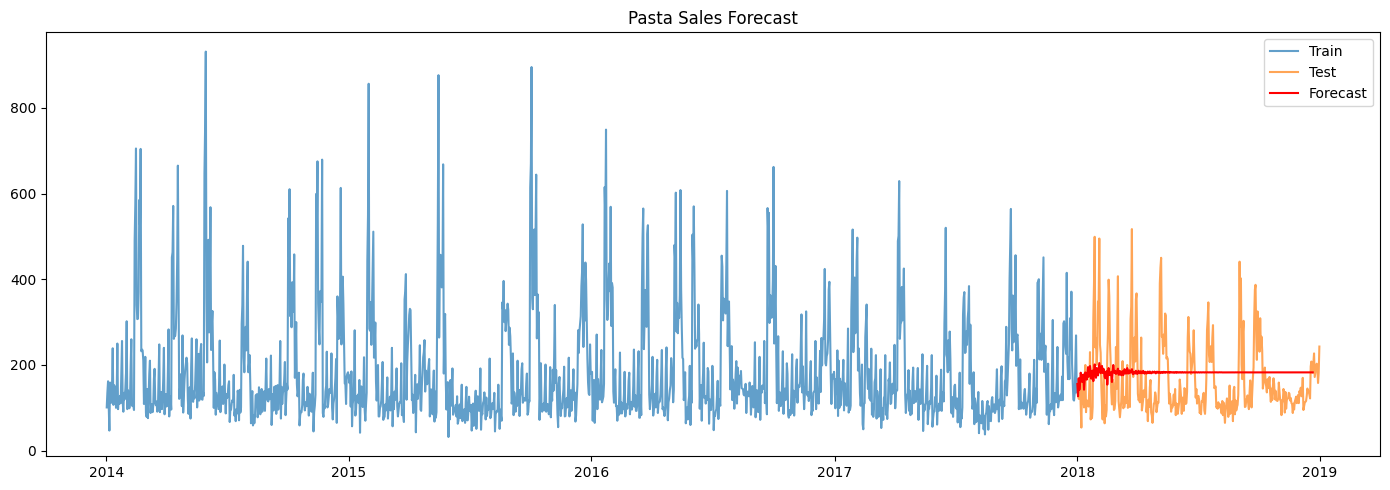

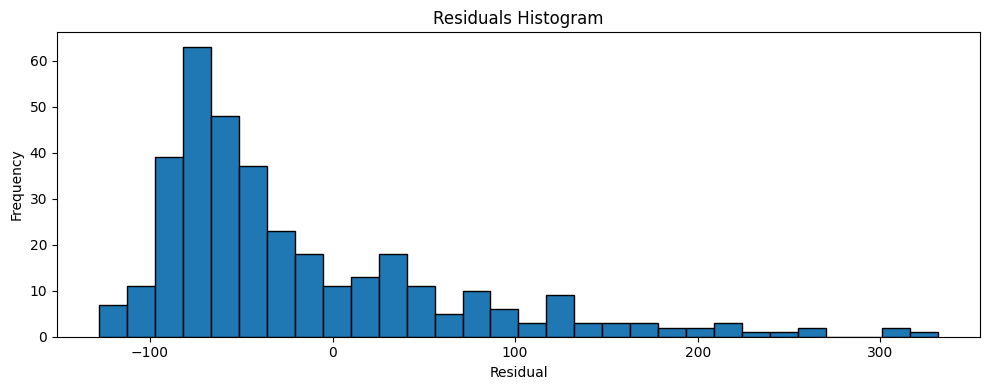

Anderson-Darling: statistic=18.2710 >= 0.7780 -> Residuals are NOT normally distributed

Ljung-Box test:
       lb_stat     lb_pvalue
1   169.823280  8.086564e-39
5   308.265187  1.672978e-64
10  364.367765  3.547816e-72
Significant autocorrelation detected at some lags


In [19]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import StatsForecastAutoETS, StatsForecastAutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.boxcox import LogTransformer, BoxCoxTransformer

print("- Baseline (mean)")
evaluate_pasta_sales_model(NaiveForecaster(strategy="mean"), y)

print("- Baseline (last)")
evaluate_pasta_sales_model(NaiveForecaster(strategy="last"), y)

print("- AutoETS (damped)")
evaluate_pasta_sales_model(StatsForecastAutoETS(damped=True), y)

print("- ARIMA")
evaluate_pasta_sales_model(StatsForecastAutoARIMA(seasonal=False), y)

print("- SARIMA (m=30)")
evaluate_pasta_sales_model(StatsForecastAutoARIMA(sp=30, seasonal=True), y)

print("- Final model with full analysis")
final_model = StatsForecastAutoARIMA(sp=30, seasonal=True)
evaluate_pasta_sales_model(final_model, y, plot_forecasts=True, analyze_residuals=True)


**Comment:**

This is a bit disappointing - none of the statistical models beat the simple last-value baseline. The baseline gets MAE=57.66 and MASE=0.86, while the best statistical model (AutoETS) only gets MAE=65.00. SARIMA is even worse at MAE=69.79.

What this tells us is that pasta sales are very volatile and hard to predict. The simple "use yesterday's value" approach works surprisingly well because there is not much exploitable structure in the data.

The residuals are far from normal (Anderson-Darling statistic=18.27) and have strong autocorrelation, so there is definitely room for improvement. But to actually beat the baseline, we would probably need external features like holidays, promotions, or maybe weather data. The current time series models just cannot capture the patterns.